# Compairing QTLs for Tomato fruit shape & Potato tuber shape on Chromosome 10

*Matthijs, Gurnoor, Arnold*

<div class=text-justify>
Reference tomato have a round fruit shape, while reference potatoes have an elongated tuber shape. Recently published article ( <a href="https://dx.doi.org/10.1038%2Fs41467-018-07216-8">DOI:10.1038/s41467-018-07216-8</a>) reveals that the presence of SLOFP20 on chromosome 10 of tomatoes is responsible for the roundness in fruit shape. However, there is no ortholog of this SLOFP20 in the reference potato DM, and this contributes to elongated tuber. In our python application we map the QTL regions in both tomato and potato, to check how well genes in both the QTL map. Consequently,  we classify genes into 3 categories, genes that occur both in tomato and potato, gene that are unique in tomato, and genes that are unique in potato. Further, we query the GO annotations in every class to see if there is any difference in GO annotations based on classes. This to find a uniqueness of every gene class.

Lastly, we summaries all the properties of the gene SLOFP20 from SGN, Uniprot and Ensembleplants database. 
</div>


Potato markers in the region pPt-458713 and pPt-473367 where as Tomato markers in the region are solcap_snp_sl_26447 and  gene188_0-i21

## Initialization

In [1]:
from diagrams import DIAGRAMS
from IPython.display import Image,SVG
import requests, pandas as pd

url = "http://pbg-ld.candygene-nlesc.surf-hosted.nl:8088/api/candYgene/queries"

QTL for fruit shape in tomatoes on chromosome 10 is marked by the genes Solyc10g075170 and Solyc10g076240. Similarly QTL for tuber shape in potatoes on chromosome 10 is marked by the genes PGSC0003DMG400006678 and PGSC0003DMG400020801.


In [2]:
#potato
pg1 = "PGSC0003DMG400006678"
pg2 = "PGSC0003DMG400020801"
#tomato
tg1 = "Solyc10g075170.1"
tg2 = "Solyc10g076240.1"

## Tomato

### Find co-ordinates of the QTL interval
Search locations of genes, and compute interval

In [3]:
try:
    resp1 = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+tg1+"'"}, 
                        headers={"accept": "application/json"})
    resp2 = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+tg2+"'"}, 
                        headers={"accept": "application/json"})
    intervalT = {}
    intervalT["chrom"] = resp1.json()["results"]["bindings"][0]["chrom"]["value"]
    intervalT["taxon_id"] = resp1.json()["results"]["bindings"][0]["taxon_id"]["value"]
    intervalT["begin_pos"] = int(resp1.json()["results"]["bindings"][0]["end_pos"]["value"])
    intervalT["end_pos"] = int(resp2.json()["results"]["bindings"][0]["begin_pos"]["value"])    
except:
    raise Exception("couldn't get interval for "+str(tg1)+" or "+str(tg2))
intervalT    

{'chrom': 'chromosome 10',
 'taxon_id': '4081',
 'begin_pos': 58895882,
 'end_pos': 59082990}

### List the candidate genes inside this QTL interval and search potato orthologs
List genes and potato orthologs inside this interval

Find tomato genes in interval

In [4]:
try:
    if intervalT["taxon_id"]=="4081":
        graph = "http://solgenomics.net/genome/Solanum_lycopersicum"
    else:
        raise Exception("unknown taxon_id "+str(intervalT["taxon_id"]))
    genes = requests.get(url+"/getFeaturesInInterval", 
                        params={"feature": "'protein_coding_gene'", "graph": graph,
                               "begin": intervalT["begin_pos"], "end": intervalT["end_pos"],
                               "chrom": intervalT["chrom"]}, 
                        headers={"accept": "application/json"})
    genesT_in_interval = []
    for gene in genes.json()["results"]["bindings"]:
        gene_id = gene["feature_id"]["value"]
        #get location
        location = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
        taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
        begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
        end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"])    
        genesT_in_interval.append([gene_id, chrom, begin_pos, end_pos, taxon_id])
    genesT_in_interval = pd.DataFrame(genesT_in_interval)
    genesT_in_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id"]
    genesT_in_interval = genesT_in_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get genes in interval "+str(intervalT["begin_pos"])+" - "+str(intervalT["begin_pos"])+" on "+str(intervalT["chrom"]))    
#display(genesT_in_interval)    

Find potato orthologs for these genes

In [5]:
try:
    ortholog_genesT_for_interval = []
    for gene_id,gene in genesT_in_interval.iterrows():
        orthologs = requests.get(url+"/getOrthologs", 
                        params={"geneid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        orthologsResult = orthologs.json()["results"]["bindings"]
        if len(orthologsResult)>0:
            for ortholog in orthologsResult:
                ortholog_id = ortholog["ortholog_id"]["value"]
                #get location
                location = requests.get(url+"/getFeatureLocation", 
                                params={"featureid": "'"+ortholog_id+"'"}, 
                                headers={"accept": "application/json"})
                chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
                taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
                begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
                end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"]) 
                ortholog_genesT_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                     gene["end_pos"],gene["taxon_id"],ortholog_id,
                                                     chrom, begin_pos, end_pos, taxon_id])
        else:
            ortholog_genesT_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                 gene["end_pos"],gene["taxon_id"], None, None,
                                                None, None, None])
    ortholog_genesT_for_interval = pd.DataFrame(ortholog_genesT_for_interval)            
    ortholog_genesT_for_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id", 
                                            "ortholog_gene_id", "ortholog_chrom", "ortholog_begin_pos",
                                            "ortholog_end_pos", "ortholog_taxon_id"]
    ortholog_genesT_for_interval = ortholog_genesT_for_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get orthologs")    

Number of orthologs for each gene

In [6]:
aggregations = { "ortholog_gene_id" : ["nunique"]}
display(ortholog_genesT_for_interval.groupby(["gene_id"]).agg(aggregations))

,ortholog_gene_id
,nunique
gene_id,
Solyc10g076170.1,0
Solyc10g076180.1,0
Solyc10g076190.1,1
Solyc10g076200.1,2
Solyc10g076210.1,2
Solyc10g076220.1,2
Solyc10g076230.1,1


### List orthologs
List orthologs for the genes found in the interval

In [7]:
index=pd.MultiIndex.from_tuples([tuple(x) for x in ortholog_genesT_for_interval[["chrom", "begin_pos", "end_pos", "ortholog_gene_id"]].to_records()], names=["gene_id", "chrom", "begin_pos", "end_pos", "ortholog_gene_id"])
display(ortholog_genesT_for_interval.set_index(index)[["ortholog_chrom", "ortholog_begin_pos", "ortholog_end_pos", "taxon_id"]])   

ortholog_chrom  \
gene_id          chrom         begin_pos end_pos  ortholog_gene_id                      
Solyc10g076170.1 chromosome 10 58981351  58981887 NaN                            None   
Solyc10g076180.1 chromosome 10 59006329  59007294 NaN                            None   
Solyc10g076190.1 chromosome 10 59045991  59047132 PGSC0003DMG400011948   chromosome 0   
Solyc10g076200.1 chromosome 10 59051770  59052216 PGSC0003DMG400011955   chromosome 0   
                                                  PGSC0003DMG400040954  chromosome 10   
Solyc10g076210.1 chromosome 10 59054478  59055612 PGSC0003DMG400020799  chromosome 10   
                                                  PGSC0003DMG400020800  chromosome 10   
Solyc10g076220.1 chromosome 10 59059828  59060961 PGSC0003DMG400020799  chromosome 10   
                                                  PGSC0003DMG400020800  chromosome 10   
Solyc10g076230.1 chromosome 10 59074041  59074647 PGSC0003DMG400020798  chromosome 10   

                                                                        ortholog_begin_pos  \
gene_id          chrom         begin_pos end_pos  ortholog_gene_id                           
Solyc10g076170.1 chromosome 10 58981351  58981887 NaN                                  NaN   
Solyc10g076180.1 chromosome 10 59006329  59007294 NaN                                  NaN   
Solyc10g076190.1 chromosome 10 59045991  59047132 PGSC0003DMG400011948          22096297.0   
Solyc10g076200.1 chromosome 10 59051770  59052216 PGSC0003DMG400011955          22098971.0   
                                                  PGSC0003DMG400040954          49170543.0   
Solyc10g076210.1 chromosome 10 59054478  59055612 PGSC0003DMG400020799          49151461.0   
                                                  PGSC0003DMG400020800          49084193.0   
Solyc10g076220.1 chromosome 10 59059828  59060961 PGSC0003DMG400020799          49151461.0   
                                                  PGSC0003DMG400020800          49084193.0   
Solyc10g076230.1 chromosome 10 59074041  59074647 PGSC0003DMG400020798          49172630.0   

                                                                        ortholog_end_pos  \
gene_id          chrom         begin_pos end_pos  ortholog_gene_id                         
Solyc10g076170.1 chromosome 10 58981351  58981887 NaN                                NaN   
Solyc10g076180.1 chromosome 10 59006329  59007294 NaN                                NaN   
Solyc10g076190.1 chromosome 10 59045991  59047132 PGSC0003DMG400011948        22097627.0   
Solyc10g076200.1 chromosome 10 59051770  59052216 PGSC0003DMG400011955        22100334.0   
                                                  PGSC0003DMG400040954        49171657.0   
Solyc10g076210.1 chromosome 10 59054478  59055612 PGSC0003DMG400020799        49152451.0   
                                                  PGSC0003DMG400020800        49085040.0   
Solyc10g076220.1 chromosome 10 59059828  59060961 PGSC0003DMG400020799        49152451.0   
                                                  PGSC0003DMG400020800        49085040.0   
Solyc10g076230.1 chromosome 10 59074041  59074647 PGSC0003DMG400020798        49173264.0   

                                                                       taxon_id  
gene_id          chrom         begin_pos end_pos  ortholog_gene_id               
Solyc10g076170.1 chromosome 10 58981351  58981887 NaN                      4081  
Solyc10g076180.1 chromosome 10 59006329  59007294 NaN                      4081  
Solyc10g076190.1 chromosome 10 59045991  59047132 PGSC0003DMG400011948     4081  
Solyc10g076200.1 chromosome 10 59051770  59052216 PGSC0003DMG400011955     4081  
                                                  PGSC0003DMG400040954     4081  
Solyc10g076210.1 chromosome 10 59054478  59055612 PGSC0003DMG400020799     4081  
                                                  PGSC0003DMG400020800     4081  
Solyc10g076220.1 chromosome 10

### Chromosomes for orthologs
Chromosomes containing the found orthologs

In [8]:
kauraggregations = {"ortholog_begin_pos" : ["min","max"], "ortholog_end_pos" : ["min","max"]}
display(ortholog_genesT_for_interval.groupby(["ortholog_taxon_id", "ortholog_chrom"]).agg(aggregations))

ortholog_gene_id
                                          nunique
ortholog_taxon_id ortholog_chrom                 
4113              chromosome 0                  2
                  chromosome 10                 4

### Diagram crosslinks
Create a diagram with crosslinks between found genes and orthologs

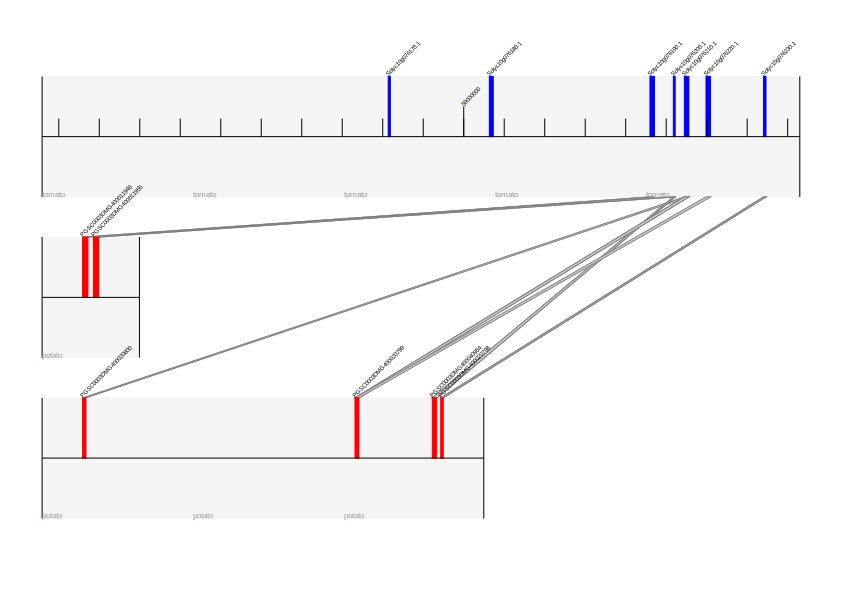

In [9]:
genesTdiagram = DIAGRAMS.crosslinks("tomato", "potato", intervalT, ortholog_genesT_for_interval)
tmpFilename = "tomato_"+tg1+"-"+tg2+"_crosslinks.svg"
genesTdiagram.write(tmpFilename, "svg")
SVG(tmpFilename)

## Potato
### Find interval
Find locations for genes, and compute interval

In [10]:
try:
    resp1 = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+pg1+"'"}, 
                        headers={"accept": "application/json"})
    resp2 = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+pg2+"'"}, 
                        headers={"accept": "application/json"})
    intervalP = {}
    intervalP["chrom"] = resp1.json()["results"]["bindings"][0]["chrom"]["value"]
    intervalP["taxon_id"] = resp1.json()["results"]["bindings"][0]["taxon_id"]["value"]
    intervalP["begin_pos"] = int(resp1.json()["results"]["bindings"][0]["end_pos"]["value"])
    intervalP["end_pos"] = int(resp2.json()["results"]["bindings"][0]["begin_pos"]["value"])    
except:
    raise Exception("couldn't get interval for "+str(pg1)+" or "+str(pg2))
intervalP   

{'chrom': 'chromosome 10',
 'taxon_id': '4113',
 'begin_pos': 48982521,
 'end_pos': 49258672}

### Find genes and orthologs
Find genes and orthologs for interval

Find potato genes in interval

In [11]:
try:
    if intervalP["taxon_id"]=="4113":
        graph = "http://solgenomics.net/genome/Solanum_tuberosum"
    else:
        raise Exception("unknown taxon_id "+str(intervalP["taxon_id"]))
    genes = requests.get(url+"/getFeaturesInInterval", 
                        params={"feature": "'protein_coding_gene'", "graph": graph,
                               "begin": intervalP["begin_pos"], "end": intervalP["end_pos"],
                               "chrom": intervalP["chrom"]}, 
                        headers={"accept": "application/json"})
    genesP_in_interval = []
    for gene in genes.json()["results"]["bindings"]:
        gene_id = gene["feature_id"]["value"]
        #get location
        location = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
        taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
        begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
        end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"])    
        genesP_in_interval.append([gene_id, chrom, begin_pos, end_pos, taxon_id])
    genesP_in_interval = pd.DataFrame(genesP_in_interval)
    genesP_in_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id"]
    genesP_in_interval = genesP_in_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get genes in interval "+str(intervalP["begin_pos"])+" - "+str(intervalP["begin_pos"])+" on "+str(intervalP["chrom"]))    
#display(genesP_in_interval)    

Find tomato orthologs for these genes

In [12]:
try:
    ortholog_genesP_for_interval = []
    for gene_id,gene in genesP_in_interval.iterrows():
        orthologs = requests.get(url+"/getOrthologs", 
                        params={"geneid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        orthologsResult = orthologs.json()["results"]["bindings"]
        if len(orthologsResult)>0:
            for ortholog in orthologsResult:
                ortholog_id = ortholog["ortholog_id"]["value"]
                #get location
                location = requests.get(url+"/getFeatureLocation", 
                                params={"featureid": "'"+ortholog_id+"'"}, 
                                headers={"accept": "application/json"})
                chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
                taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
                begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
                end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"]) 
                ortholog_genesP_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                     gene["end_pos"],gene["taxon_id"],ortholog_id,
                                                     chrom, begin_pos, end_pos, taxon_id])
        else:
            ortholog_genesP_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                 gene["end_pos"],gene["taxon_id"], None, None,
                                                None, None, None])
    ortholog_genesP_for_interval = pd.DataFrame(ortholog_genesP_for_interval)            
    ortholog_genesP_for_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id", 
                                            "ortholog_gene_id", "ortholog_chrom", "ortholog_begin_pos",
                                            "ortholog_end_pos", "ortholog_taxon_id"]
    ortholog_genesP_for_interval = ortholog_genesP_for_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get orthologs")  

Number of orthologs for each gene

In [13]:
aggregations = { "ortholog_gene_id" : ["nunique"]}
display(ortholog_genesP_for_interval.groupby(["gene_id"]).agg(aggregations))

,ortholog_gene_id
,nunique
gene_id,
PGSC0003DMG400006679,0
PGSC0003DMG400006680,0
PGSC0003DMG400006681,0
PGSC0003DMG400020795,0
PGSC0003DMG400020797,0
PGSC0003DMG400020798,2
PGSC0003DMG400020799,2
PGSC0003DMG400020800,2


### List orthologs
List orthologs for the genes found in the interval

In [14]:
index=pd.MultiIndex.from_tuples([tuple(x) for x in ortholog_genesP_for_interval[["chrom", "begin_pos", "end_pos", "ortholog_gene_id"]].to_records()], names=["gene_id", "chrom", "begin_pos", "end_pos", "ortholog_gene_id"])
display(ortholog_genesP_for_interval.set_index(index)[["ortholog_chrom", "ortholog_begin_pos", "ortholog_end_pos", "taxon_id"]])   

ortholog_chrom  \
gene_id              chrom         begin_pos end_pos  ortholog_gene_id                  
PGSC0003DMG400006679 chromosome 10 49022687  49023709 NaN                        None   
PGSC0003DMG400006680 chromosome 10 49040786  49046010 NaN                        None   
PGSC0003DMG400006681 chromosome 10 49064472  49065184 NaN                        None   
PGSC0003DMG400020795 chromosome 10 49247297  49254377 NaN                        None   
PGSC0003DMG400020797 chromosome 10 49199138  49201970 NaN                        None   
PGSC0003DMG400020798 chromosome 10 49172630  49173264 Solyc10g075120.1  chromosome 10   
                                                      Solyc10g076230.1  chromosome 10   
PGSC0003DMG400020799 chromosome 10 49151461  49152451 Solyc10g076210.1  chromosome 10   
                                                      Solyc10g076220.1  chromosome 10   
PGSC0003DMG400020800 chromosome 10 49084193  49085040 Solyc10g076210.1  chromosome 10   
                                                      Solyc10g076220.1  chromosome 10   
PGSC0003DMG400035649 chromosome 10 49174387  49174710 NaN                        None   
PGSC0003DMG400039458 chromosome 10 49235999  49240574 NaN                        None   
PGSC0003DMG400040544 chromosome 10 49108641  49111957 Solyc01g066890.1   chromosome 1   
                                                      Solyc07g041360.1   chromosome 7   
PGSC0003DMG400040954 chromosome 10 49170543  49171657 Solyc10g076200.1  chromosome 10   
PGSC0003DMG400045482 chromosome 10 49092329  49093552 NaN                        None   

                                                                        ortholog_begin_pos  \
gene_id              chrom         begin_pos end_pos  ortholog_gene_id                       
PGSC0003DMG400006679 chromosome 10 49022687  49023709 NaN                              NaN   
PGSC0003DMG400006680 chromosome 10 49040786  49046010 NaN                              NaN   
PGSC0003DMG400006681 chromosome 10 49064472  49065184 NaN                              NaN   
PGSC0003DMG400020795 chromosome 10 49247297  49254377 NaN                              NaN   
PGSC0003DMG400020797 chromosome 10 49199138  49201970 NaN                              NaN   
PGSC0003DMG400020798 chromosome 10 49172630  49173264 Solyc10g075120.1          58847992.0   
                                                      Solyc10g076230.1          59074041.0   
PGSC0003DMG400020799 chromosome 10 49151461  49152451 Solyc10g076210.1          59054478.0   
                                                      Solyc10g076220.1          59059828.0   
PGSC0003DMG400020800 chromosome 10 49084193  49085040 Solyc10g076210.1          59054478.0   
                                                      Solyc10g076220.1          59059828.0   
PGSC0003DMG400035649 chromosome 10 49174387  49174710 NaN                              NaN   
PGSC0003DMG400039458 chromosome 10 49235999  49240574 NaN                              NaN   
PGSC0003DMG400040544 chromosome 10 49108641  49111957 Solyc01g066890.1          75142075.0   
                                                      Solyc07g041360.1          52534390.0   
PGSC0003DMG400040954 chromosome 10 49170543  49171657 Solyc10g076200.1          59051770.0   
PGSC0003DMG400045482 chromosome 10 49092329  49093552 NaN                              NaN   

                                                                        ortholog_end_pos  \
gene_id              chrom         begin_pos end_pos  ortholog_gene_id                     
PGSC0003DMG400006679 chromosome 10 49022687  49023709 NaN                            NaN   
PGSC0003DMG400006680 chromosome 10 49040786  49046010 NaN                            NaN   
PGSC0003DMG400006681 chromosome 10 49064472  49065184 NaN                            NaN   
PGSC0003DMG400020795 chromosome 10 49247297  49254377 NaN                            NaN   
PGSC0003DMG400020797 chromosome 10 49199

### Chromosomes for orthologs
Chromosomes containing the found orthologs

In [15]:
kauraggregations = {"ortholog_begin_pos" : ["min","max"], "ortholog_end_pos" : ["min","max"]}
display(ortholog_genesP_for_interval.groupby(["ortholog_taxon_id", "ortholog_chrom"]).agg(aggregations))

ortholog_gene_id
                                          nunique
ortholog_taxon_id ortholog_chrom                 
4081              chromosome 1                  1
                  chromosome 10                 5
                  chromosome 7                  1

### Diagram crosslinks
Create a diagram with crosslinks between found genes and orthologs

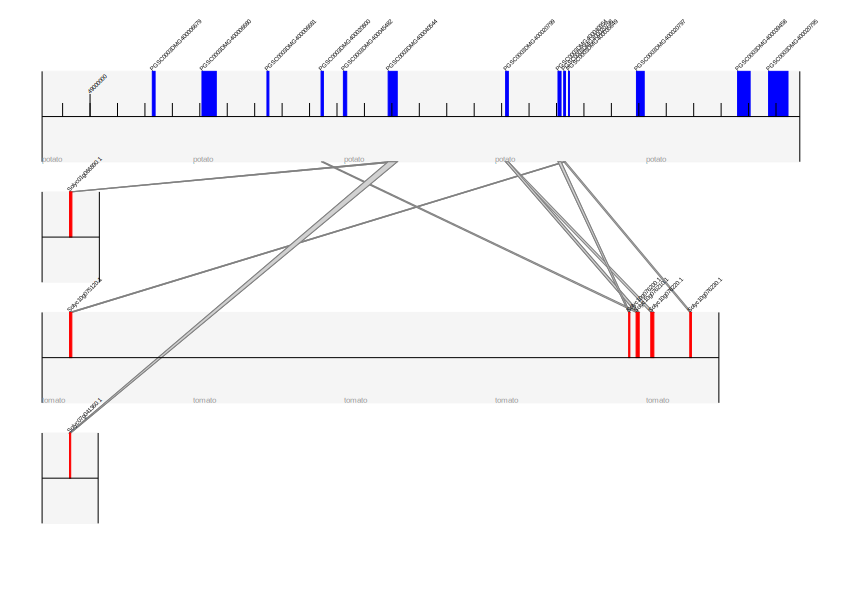

In [16]:
genesPdiagram = DIAGRAMS.crosslinks("potato", "tomato", intervalP, ortholog_genesP_for_interval)
tmpFilename = "potato_"+pg1+"-"+pg2+".svg"
genesPdiagram.write(tmpFilename, "svg")
SVG(tmpFilename)

# Annotations
Compare GO annotatios in all three classes

Genes, orthologs for potato and tomato and annotations

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

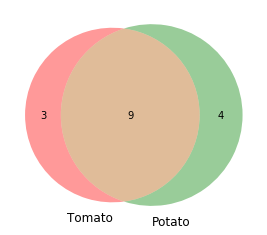

In [18]:
setT = genesT_in_interval.index.unique()
setP = genesP_in_interval.index.unique()
setTP = setT & ortholog_genesP_for_interval["ortholog_gene_id"].dropna().unique()
setPT = setP & ortholog_genesT_for_interval["ortholog_gene_id"].dropna().unique()
setT = list(set(setT)-set(setTP))
setP = list(set(setP)-set(setPT))
venn2(subsets = (len(setT), len(setTP), len(setP)), set_labels = ("Tomato", "Potato"))
#venn2(subsets = (1,2,3), set_labels = ("Tomato", "Potato"))
plt.show()

## Only in Tomato interval

In [19]:
print(*setT, sep = "\n")

Solyc10g076170.1
Solyc10g076180.1
Solyc10g076190.1


In [20]:
try:
    termsT = []
    for gene_id in setT:
        annotations = requests.get(url+"/getGeneAnnotations", 
                                   params={"geneid": "'"+gene_id+"'"}, 
                                   headers={"accept": "application/json"})        
        for annotation in annotations.json()["results"]["bindings"]:
            uniprot_goa = annotation["uniprot_goa"]["value"].strip()
            if uniprot_goa=="":
                termsT.append([gene_id, None])
            else:
                for go_id in uniprot_goa.split(","):                    
                    termsT.append([gene_id, go_id.strip()])
            break        
    termsT = pd.DataFrame(termsT)
    termsT.columns = ["gene_id", "go_id"]
    termsT = termsT.set_index(["gene_id"])
except:
    raise Exception("couldn't get terms for genes") 

In [21]:
print(*set([go_id for go_id in termsT["go_id"] if not (go_id == None)]), sep="\n")

GO:0045892
GO:0046872
GO:0006979
GO:0003677
GO:0004601
GO:0005576
GO:0020037
GO:0042744


In [22]:
termsT.set_index(["go_id"], append=True)

Empty DataFrame
Columns: []
Index: [(Solyc10g076170.1, nan), (Solyc10g076180.1, GO:0003677), (Solyc10g076180.1, GO:0045892), (Solyc10g076190.1, GO:0004601), (Solyc10g076190.1, GO:0005576), (Solyc10g076190.1, GO:0006979), (Solyc10g076190.1, GO:0020037), (Solyc10g076190.1, GO:0042744), (Solyc10g076190.1, GO:0046872)]

## Only in Potato

In [23]:
print(*setP, sep = "\n")

PGSC0003DMG400020797
PGSC0003DMG400006681
PGSC0003DMG400020795
PGSC0003DMG400006679
PGSC0003DMG400040544
PGSC0003DMG400045482
PGSC0003DMG400039458
PGSC0003DMG400035649
PGSC0003DMG400006680


In [24]:
try:
    termsP = []
    for gene_id in setP:
        annotations = requests.get(url+"/getGeneAnnotations", 
                                   params={"geneid": "'"+gene_id+"'"}, 
                                   headers={"accept": "application/json"})        
        for annotation in annotations.json()["results"]["bindings"]:
            uniprot_goa = annotation["uniprot_goa"]["value"].strip()
            if uniprot_goa=="":
                termsP.append([gene_id, None])
            else:
                for go_id in uniprot_goa.split(","):                    
                    termsP.append([gene_id, go_id.strip()])
            break        
    termsP = pd.DataFrame(termsP)
    termsP.columns = ["gene_id", "go_id"]
    termsP = termsP.set_index(["gene_id"])
except:
    raise Exception("couldn't get terms for genes") 

In [25]:
print(*set([go_id for go_id in termsP["go_id"] if not (go_id == None)]), sep="\n")

In [26]:
termsP.set_index(["go_id"], append=True)

,
gene_id,go_id
PGSC0003DMG400020797,NaN
PGSC0003DMG400006681,NaN
PGSC0003DMG400020795,NaN
PGSC0003DMG400006679,NaN
PGSC0003DMG400040544,NaN
PGSC0003DMG400045482,NaN
PGSC0003DMG400039458,NaN
PGSC0003DMG400035649,NaN
PGSC0003DMG400006680,NaN


## Both in Tomato and Potato

In [27]:
print(*setTP, sep = "\n")
#print(*setPT, sep = "\n")

Solyc10g076200.1
Solyc10g076210.1
Solyc10g076220.1
Solyc10g076230.1


In [28]:
try:
    termsTP = []
    for gene_id in setTP:
        annotations = requests.get(url+"/getGeneAnnotations", 
                                   params={"geneid": "'"+gene_id+"'"}, 
                                   headers={"accept": "application/json"})        
        for annotation in annotations.json()["results"]["bindings"]:
            uniprot_goa = annotation["uniprot_goa"]["value"].strip()
            if uniprot_goa=="":
                termsTP.append([gene_id, None])
            else:
                for go_id in uniprot_goa.split(","):                    
                    termsTP.append([gene_id, go_id.strip()])
            break        
    termsTP = pd.DataFrame(termsTP)
    termsTP.columns = ["gene_id", "go_id"]
    termsTP = termsTP.set_index(["gene_id"])
except:
    raise Exception("couldn't get terms for genes") 

In [29]:
print(*set([go_id for go_id in termsTP["go_id"] if not (go_id == None)]), sep="\n")

GO:0016020
GO:0046872
GO:0006979
GO:0020037
GO:0008289
GO:0004601
GO:0005576
GO:0006869
GO:0042744


In [30]:
termsTP.set_index(["go_id"], append=True)

Empty DataFrame
Columns: []
Index: [(Solyc10g076200.1, GO:0006869), (Solyc10g076200.1, GO:0008289), (Solyc10g076200.1, GO:0016020), (Solyc10g076210.1, GO:0004601), (Solyc10g076210.1, GO:0005576), (Solyc10g076210.1, GO:0006979), (Solyc10g076210.1, GO:0020037), (Solyc10g076210.1, GO:0042744), (Solyc10g076210.1, GO:0046872), (Solyc10g076220.1, GO:0004601), (Solyc10g076220.1, GO:0005576), (Solyc10g076220.1, GO:0006979), (Solyc10g076220.1, GO:0020037), (Solyc10g076220.1, GO:0042744), (Solyc10g076220.1, GO:0046872), (Solyc10g076230.1, nan)]

## Exploring the Annotations of Gene *Solyc10g076180.1*

- GO Annotation
- PPI 
- STRING
- KEGG
- ALL Orthologs
- Species with no Orthologs

In [31]:
try:
    ortholog_paralog_genesT_for_interval = []
    for gene_id,gene in genesT_in_interval.iterrows():
        #get paralogs, and then orthologs
        paralogs = requests.get(url+"/getParalogs", 
                        params={"geneid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        for paralog in paralogs.json()["results"]["bindings"]:
            paralog_id = paralog["paralog_id"]["value"]
            #get orthologs for paralog
            orthologs = requests.get(url+"/getOrthologs", 
                        params={"geneid": "'"+paralog_id+"'"}, 
                        headers={"accept": "application/json"})
            for ortholog in orthologs.json()["results"]["bindings"]:
                ortholog_id = ortholog["ortholog_id"]["value"]
                #get location
                location = requests.get(url+"/getFeatureLocation", 
                                params={"featureid": "'"+ortholog_id+"'"}, 
                                headers={"accept": "application/json"})
                chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
                taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
                begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
                end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"]) 
                ortholog_paralog_genesT_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                             gene["end_pos"],gene["taxon_id"],paralog_id,
                                                             "PARALOG", ortholog_id,
                                                             chrom, begin_pos, end_pos, taxon_id])
        #get direct orthologs
        orthologs = requests.get(url+"/getOrthologs", 
                        params={"geneid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        for ortholog in orthologs.json()["results"]["bindings"]:
            ortholog_id = ortholog["ortholog_id"]["value"]
            #get location
            location = requests.get(url+"/getFeatureLocation", 
                            params={"featureid": "'"+ortholog_id+"'"}, 
                            headers={"accept": "application/json"})
            chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
            taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
            begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
            end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"]) 
            ortholog_paralog_genesT_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                 gene["end_pos"],gene["taxon_id"],None, "ORTHOLOG", ortholog_id,
                                                 chrom, begin_pos, end_pos, taxon_id])    
    #create dataframe        
    ortholog_paralog_genesT_for_interval = pd.DataFrame(ortholog_paralog_genesT_for_interval)            
    ortholog_paralog_genesT_for_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id", "paralog_gene_id",
                                            "path", "ortholog_gene_id", "ortholog_chrom", "ortholog_begin_pos",
                                            "ortholog_end_pos", "ortholog_taxon_id"]
    ortholog_paralog_genesT_for_interval = ortholog_paralog_genesT_for_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get orthologs")  

Number of orthologs for each gene

In [32]:
aggregations = { "ortholog_gene_id" : ["nunique"]}
display(ortholog_paralog_genesT_for_interval.groupby(["gene_id"]).agg(aggregations))

,ortholog_gene_id
,nunique
gene_id,
Solyc10g076180.1,10
Solyc10g076190.1,11
Solyc10g076200.1,28
Solyc10g076210.1,11
Solyc10g076220.1,11
Solyc10g076230.1,1


In [33]:
index=pd.MultiIndex.from_tuples([tuple(x) for x in ortholog_paralog_genesT_for_interval[["chrom", "begin_pos", "end_pos", "paralog_gene_id", "ortholog_gene_id"]].to_records()], names=["gene_id", "chrom", "begin_pos", "end_pos", "paralog_gene_id", "ortholog_gene_id"])
display(ortholog_paralog_genesT_for_interval.set_index(index)[["path", "ortholog_chrom", "ortholog_begin_pos", "ortholog_end_pos"]])      

path  \
gene_id          chrom         begin_pos end_pos  paralog_gene_id  ortholog_gene_id                 
Solyc10g076180.1 chromosome 10 59006329  59007294 Solyc01g007800.2 PGSC0003DMG400016415   PARALOG   
                                                  Solyc02g072030.1 PGSC0003DMG400028460   PARALOG   
                                                  Solyc02g085500.2 PGSC0003DMG400012688   PARALOG   
                                                  Solyc03g034100.2 PGSC0003DMG400017788   PARALOG   
                                                  Solyc04g080210.1 PGSC0003DMG400044629   PARALOG   
                                                  Solyc06g082460.1 PGSC0003DMG400030384   PARALOG   
                                                  Solyc08g068170.1 PGSC0003DMG400014511   PARALOG   
                                                  Solyc09g018200.1 PGSC0003DMG400004418   PARALOG   
                                                  Solyc10g082050.1 PGSC0003DMG400028155   PARALOG   
                                                  Solyc11g068780.1 PGSC0003DMG400019628   PARALOG   
Solyc10g076190.1 chromosome 10 59045991  59047132 Solyc03g025380.2 PGSC0003DMG400015801   PARALOG   
                                                  Solyc05g050880.2 PGSC0003DMG400006993   PARALOG   
                                                  Solyc05g052280.2 PGSC0003DMG400011640   PARALOG   
                                                  Solyc06g050440.2 PGSC0003DMG400014055   PARALOG   
                                                  Solyc06g082420.2 PGSC0003DMG400030382   PARALOG   
                                                  Solyc07g055190.2 PGSC0003DMG400020437   PARALOG   
                                                  Solyc09g018590.1 PGSC0003DMG400026575   PARALOG   
                                                  Solyc10g076210.1 PGSC0003DMG400020799   PARALOG   
                                                                   PGSC0003DMG400020800   PARALOG   
                                                  Solyc10g076220.1 PGSC0003DMG400020799   PARALOG   
                                                                   PGSC0003DMG400020800   PARALOG   
                                                  Solyc11g018800.1 PGSC0003DMG400015106   PARALOG   
                                                  NaN              PGSC0003DMG400011948  ORTHOLOG   
Solyc10g076200.1 chromosome 10 59051770  59052216 Solyc01g081590.2 PGSC0003DMG400031126   PARALOG   
                                                  Solyc01g081600.2 PGSC0003DMG400031127   PARALOG   
                                                  Solyc01g090350.2 PGSC0003DMG400025988   PARALOG   
                                                  Solyc01g090360.2 PGSC0003DMG400025987   PARALOG   
                                                  Solyc02g087910.1 PGSC0003DMG400001322   PARALOG   
                                                  Solyc06g005770.1 PGSC0003DMG400020821   PARALOG   
                                                  Solyc06g005780.1 PGSC0003DMG400020837   PARALOG   
...                                                                                           ...   
                                                  NaN              PGSC0003DMG400011955  ORTHOLOG   
                                                                   PGSC0003DMG400040954  ORTHOLOG   
Solyc10g076210.1 chromosome 10 59054478  59055612 Solyc03g025380.2 PGSC0003DMG400015801   PARALOG   
                                                  Solyc05g050880.2 PGSC0003DMG400006993   PARALOG   
                                                  Solyc05g052280.2 PGSC0003DMG400011640   PARALOG   
                                                  Solyc06g050440.2 PGSC0003DMG400014055   PARALOG   
                                                  Solyc06g082420.2 PGSC0003DMG400030382   PARALOG   
                                                  Sol